In [ ]:
!pip install transformers

     |████████████████████████████████| 1.1MB 5.5MB/s 
     |████████████████████████████████| 1.1MB 31.1MB/s 
     |████████████████████████████████| 890kB 42.3MB/s 
     |████████████████████████████████| 3.0MB 47.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=fee14901933e9ab7fff503de45ac8dd9d1879eab5963e1a88e7aae9f14dbd0e5
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import transformers
from transformers import AutoModel, BertTokenizer, BertForMaskedLM, AdamW
import json
device = torch.device("cuda")

In [ ]:
#Simply read in the text data
with open('/content/furniture_cleaned.json','r') as file:
    furniture = file.read()

In [ ]:
data = json.loads(furniture)

In [ ]:
corpus = []
for d in data:
  # We're currently training on the artist quotes to understand the most about their design intents
   if 'quotes' in d:
    corpus.append(d['quotes'])

In [ ]:
#Load model and tokenizer from huggingface
bert = BertForMaskedLM.from_pretrained('bert-base-uncased', output_hidden_states = True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Simply flattening the list
corpus = [text for quotes_list in corpus for text in quotes_list ]

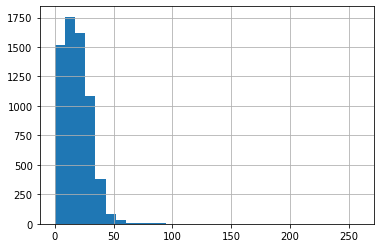

In [ ]:
seq_len = [len(i.split()) for i in corpus]

pd.Series(seq_len).hist(bins = 30)


In [ ]:
max_seq_len = 50

In [ ]:
# tokenize and encode sequences in the training set, also pads the tokens
tokens_train = tokenizer.batch_encode_plus(
    corpus,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [ ]:
def get_proper_logits_labels(sent_id, logits, indexes):
  labels = torch.zeros(len(sent_id), dtype=torch.long)
  # 30522 is the length of the vocabulary
  logits_new = torch.zeros(len(logits), 30522, dtype=torch.float64)
  for i in range(len(labels)):
    # try:
    labels[i] = sent_id[i][indexes[i]]
    logits_new[i] = logits[i][indexes[i]]
    # except:
      # print(labels)
      # print(sent_id)
      # print(indexes)
      # print(i)
      # labels[i] = sent_id[i][indexes[i]]
      # logits_new[i] = logits[i][indexes[i]]
  return labels, logits_new

In [ ]:
bert = bert.to(device)

In [ ]:
# function to train the model
def train():

  #Create AdamW optimizer
  optim = AdamW(bert.parameters(), lr=5e-5)

  # loss function
  cross_entropy = nn.CrossEntropyLoss()
  
  bert.train()

  maskid = tokenizer.vocab['[MASK]']

  for sent_id, att_mask in train_dataloader:
    
    #Create a masked copy of ids for the model to predict
    sent_id = sent_id.to(device)
    inp = sent_id.clone()
    indexes = [1] * 16
    att_mask = att_mask.to(device)

    #Mask a word in each sentence for the model to predict
    for sentence in inp:
      i = np.random.randint(0, max_seq_len)
      #Randomly choose a word to mask that isn't just a pad
      while (sentence[i] == 0):
        i = np.random.randint (0, max_seq_len)
      sentence[i] = maskid
      indexes.append(i)

    l = bert(inp, attention_mask = att_mask, return_dict = True)
    logits = l.logits
    
    # print(len(indexes))
    # print(inp.shape)
    # print(sent_id.shape)
    # print(logits.shape)
    labels, logits = get_proper_logits_labels(sent_id, logits, indexes)

    loss = cross_entropy(logits, labels)
    loss.backward(retain_graph=True)
    optim.step()

In [ ]:
for i in range(5):
  #save weights of model
  path = 'saved_weights.pt'
  torch.save(bert.state_dict(), 'saved_weights' + str(i) + '.pt')
  print("Started epoch " + str(i))
  train()


Started epoch 0
Started epoch 1
Started epoch 2
Started epoch 3
Started epoch 4


In [ ]:
from google.colab import files

for i in range(5):
  #save weights of model
  files.download('saved_weights' + str(i) + '.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
bert.load_state_dict(torch.load('saved_weights4.pt'))

<All keys matched successfully>

In [ ]:
def get_embedding(s, words = None):
  # tokenize and encode sequences in the test set
    tokens = tokenizer.batch_encode_plus(
        [s],
        max_length = 50,
        pad_to_max_length=True,
        truncation=True,
        return_token_type_ids=False
    )

    bert.eval()

    seq = torch.tensor(tokens['input_ids'])
    mask = torch.tensor(tokens['attention_mask'])

    # dataLoader for train set
    

    torch.no_grad()
    outputs = bert(seq, mask)
    hidden_states = outputs[1]
    embeddings = hidden_states[-2][0]
    embeddings = torch.sum(token_vecs)  
    return embeddings

In [ ]:
out = get_embedding('Bro what is up')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
hidden_states

(tensor([[[-0.5306, -0.5524,  1.0517,  ..., -1.2708,  1.0737, -1.4077],
          [-0.4816, -0.4939,  0.5471,  ..., -0.5976, -0.1390, -1.7710],
          [-1.1673, -0.4776,  1.0655,  ..., -0.4274,  0.9424, -2.1420],
          ...,
          [-0.7248, -0.6990,  1.3732,  ...,  0.3083, -0.4028, -0.5759],
          [-0.7088, -0.7440,  1.3811,  ..., -0.7950,  0.4830, -1.7952],
          [ 0.4350,  0.1419,  1.2721,  ..., -0.7501, -0.3418, -0.5896]]],
        grad_fn=<NativeLayerNormBackward>),
 tensor([[[ 0.3137,  0.7381, -0.5180,  ...,  0.5350, -0.1954, -0.1805],
          [ 0.3038,  0.7620, -0.5090,  ...,  0.5296, -0.2141, -0.1812],
          [ 0.3113,  0.7377, -0.5206,  ...,  0.5371, -0.1930, -0.1650],
          ...,
          [ 0.2913,  0.7583, -0.5208,  ...,  0.5404, -0.2028, -0.1532],
          [ 0.2921,  0.7609, -0.5179,  ...,  0.5374, -0.2083, -0.1581],
          [ 0.2912,  0.7590, -0.5202,  ...,  0.5402, -0.2037, -0.1544]]],
        grad_fn=<NativeLayerNormBackward>),
 tensor([[[ 0.

In [ ]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 50
Number of hidden units: 768


In [ ]:
token_vecs = hidden_states[-2][0]
token_vecs = torch.sum(token_vecs)